# 🚗 Driver Behavior Classification - EDA

**Author:** Reza Mirzaeifard
**Date:** December 2025
**Dataset:** UAH-DriveSet (Real-world driving telemetry)

---

## ⚠️ IMPORTANT: If imports fail

**Restart the Jupyter Kernel first!**
- In JupyterLab: `Kernel → Restart Kernel`
- In PyCharm: `Run → Restart Kernel`


In [1]:
# Step 1: Clear all cached src modules
import sys
for mod in list(sys.modules.keys()):
    if mod.startswith('src'):
        del sys.modules[mod]

# Step 2: Add project root to path
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")


Project root: /Users/rezami/PycharmProjects/ABAX


In [2]:
# Step 3: Standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Project imports
from src.data import load_uah_driveset
from src.features import (
    analyze_class_distribution,
    analyze_correlations,
    analyze_outliers_dataframe,
    generate_data_quality_report,
    analyze_driver_distribution,
    print_score_mapping_explanation,
    print_outlier_summary,
)
from src.visualization import (
    setup_style,
    plot_class_distribution_from_result,
    plot_driver_behavior_distribution,
    plot_feature_by_target,
    plot_outlier_summary,
    plot_correlation_matrix,
)
from src.utils import (
    print_dataset_info,
    print_class_distribution_result,
    print_success,
)

setup_style()
print_success('All imports successful!')


✅ All imports successful!


## 1. Introduction

### Problem Statement
Predict driver behavior: **NORMAL / DROWSY / AGGRESSIVE**

### Dataset: UAH-DriveSet
- **Source**: University of Alcalá (naturalistic driving data)
- **Drivers**: 6 drivers (D1-D6)
- **Behaviors**: 3 classes (Normal, Drowsy, Aggressive)
- **Road types**: Motorway, Secondary
- **Data**: ~40 trips with telemetry features

### Business Relevance (ABAX)
- **Fleet safety**: Identify high-risk drivers proactively
- **Insurance (UBI)**: Behavior-based premium adjustment
- **Driver coaching**: Targeted feedback for improvement
- **Compliance**: Monitor driving patterns for regulations

### Key Innovation: Driver-Level Splitting
**Why it matters**: Random splits leak information (same driver in train & test).
**Solution**: D6 always in test + stratified samples = 20% test → ensures generalization to NEW drivers.

### Feature Engineering Philosophy

**Q: Why aggregate trip-level features instead of time-series?**

**A:**
1. **Variable trip lengths**: Trips range from 13-26km with different durations
2. **Real-world applicability**: Aggregate statistics work without fixed window lengths
3. **Domain knowledge**: Ratios and scores (% aggressive maneuvers) are scale-invariant
4. **Production-ready**: Easy to compute in real-time systems

**Q: What about different window lengths in production?**

**A:**
- **Current approach**: Aggregate over entire trips (no fixed window needed)
- **Alternative 1**: Rolling statistics over fixed windows (e.g., 5-min segments)
- **Alternative 2**: RNN/Transformer on raw time-series with padding/truncation
- **Our choice**: Practical, interpretable, and scalable for deployment

---


## 2. Understanding Score Mapping (Accelerometer → Scores)

The UAH-DriveSet uses the **DriveSafe iOS app** to compute behavioral scores from raw accelerometer data.


In [3]:
# Display the score mapping explanation
print(print_score_mapping_explanation())



UAH-DriveSet Score Mapping (from DriveSafe App)

The scores are computed by the DriveSafe iOS app from accelerometer data:

1. **Raw Data Collection**:
   - Accelerometer: 3-axis acceleration at ~50Hz
   - GPS: Position, speed at ~1Hz

2. **Event Detection** (from SEMANTIC_FINAL.txt):
   - Low/Medium/High Accelerations (Lacc, Macc, Hacc)
   - Low/Medium/High Brakings (Lbra, Mbra, Hbra)  
   - Low/Medium/High Turnings (Ltur, Mtur, Htur)
   
   Events are classified by acceleration magnitude thresholds:
   - Low: 0.2-0.5g
   - Medium: 0.5-0.8g
   - High: >0.8g

3. **Score Computation** (0-100 scale):
   - score_accelerations: Based on Lacc, Macc, Hacc counts
   - score_brakings: Based on Lbra, Mbra, Hbra counts
   - score_turnings: Based on Ltur, Mtur, Htur counts
   - score_weaving: Lane discipline from lateral movement
   - score_drifting: Lane keeping from GPS trajectory
   - score_overspeeding: Speed compliance vs road limits
   - score_following: Following distance estimation
   - 

## 3. Load Data with Driver Information

We preserve driver information for proper **driver-level splitting** later.


In [4]:
dataset = load_uah_driveset(
    data_dir=str(project_root / 'data' / 'UAH-DRIVESET-v1'),
    task='classification',
    return_driver_info=True
)

print_dataset_info(dataset.info)

df = pd.DataFrame(dataset.X, columns=dataset.feature_names)
df['behavior'] = dataset.y.values

print(f"\n🔍 Shape: {df.shape}")
print(f"\n📋 First 10 samples:")
df.head(10)



📊 Dataset: UAH-DriveSet
   Samples: 40
   Features: 11
   Task: classification

🔍 Shape: (40, 13)

📋 First 10 samples:


,score_total,score_accelerations,score_brakings,score_turnings,score_weaving,score_drifting,score_overspeeding,score_following,ratio_normal,ratio_drowsy,ratio_aggressive,driver,behavior
0,90.0,100.0,100.0,100.0,100.0,63.7,66.2,100.0,0.742,0.145,0.113,D1,NORMAL
1,80.4,100.0,49.1,100.0,100.0,53.7,59.8,100.0,0.480,0.278,0.242,D1,DROWSY
2,70.7,100.0,0.0,100.0,100.0,90.0,79.3,25.6,0.428,0.063,0.509,D1,AGGRESSIVE
3,89.4,100.0,100.0,100.0,100.0,26.2,100.0,99.6,0.464,0.443,0.093,D1,DROWSY
4,62.7,100.0,0.0,59.7,100.0,61.5,95.9,22.1,0.172,0.233,0.595,D1,AGGRESSIVE
5,84.5,100.0,100.0,53.7,100.0,47.0,90.8,100.0,0.652,0.212,0.136,D1,NORMAL
6,87.8,100.0,100.0,100.0,33.3,82.1,100.0,99.5,0.411,0.436,0.153,D1,NORMAL
7,67.2,100.0,0.0,100.0,100.0,92.6,78.0,0.0,0.287,0.047,0.666,D2,AGGRESSIVE
8,87.5,75.6,75.6,100.0,100.0,65.0,100.0,96.2,0.616,0.210,0.174,D2,DROWSY
9,55.0,73.1,5.5,49.4,100.0,59.6,97.8,0.0,0.003,0.243,0.755,D2,AGGRESSIVE


## 4. Save Processed Data


In [5]:
processed_dir = project_root / 'data' / 'processed'
processed_dir.mkdir(exist_ok=True)

save_path = processed_dir / 'uah_classification.csv'
df.to_csv(save_path, index=False)
print(f'\n💾 Saved to: {save_path}')
print(f'   Shape: {df.shape}')



💾 Saved to: /Users/rezami/PycharmProjects/ABAX/data/processed/uah_classification.csv
   Shape: (40, 13)


## 5. Data Quality Report

Using our `generate_data_quality_report()` function for comprehensive analysis.


In [6]:
quality_report = generate_data_quality_report(
    df=df,
    target_column='behavior',
    task_type='classification'
)

print(quality_report.summary())


📊 Data Quality Report
   Samples: 40
   Features: 12 (11 numerical, 1 categorical)
   Imbalanced: No


## 6. Class Distribution

Using our `analyze_class_distribution()` function.



📊 Class Distribution Analysis:
   Counts: {'NORMAL': 17, 'DROWSY': 12, 'AGGRESSIVE': 11}
   Percentages: {'NORMAL': '42.5%', 'DROWSY': '30.0%', 'AGGRESSIVE': '27.5%'}

✅ Classes reasonably balanced (ratio: 1.5)


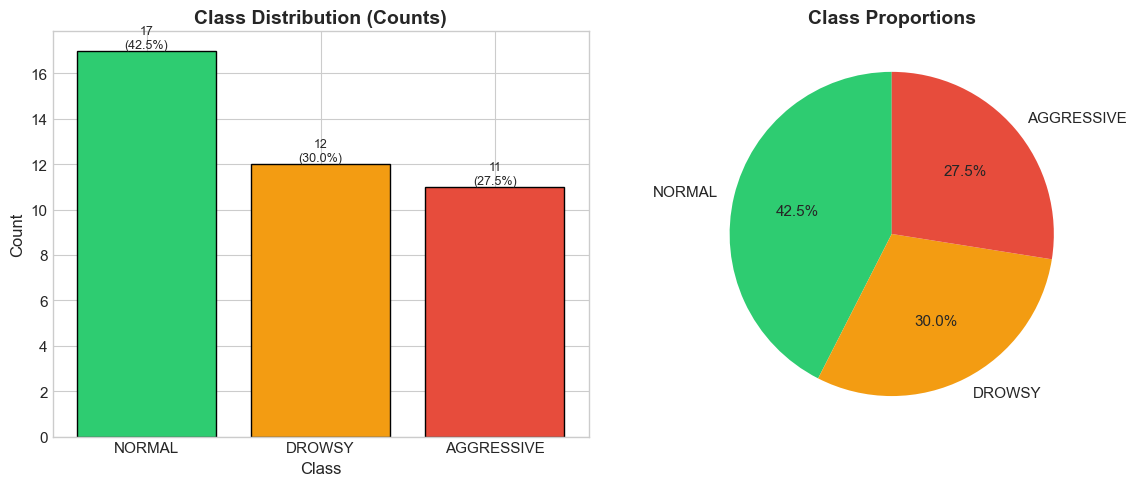

In [7]:
class_result = analyze_class_distribution(df['behavior'])

print_class_distribution_result(class_result)

# Plot using our visualization function
fig = plot_class_distribution_from_result(class_result, title='Driver Behavior Distribution')
plt.savefig(project_root / 'results' / 'figures' / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Driver Distribution

Using our `analyze_driver_distribution()` function.



👥 Trips per driver:
   D1: 7 trips
   D2: 7 trips
   D3: 7 trips
   D4: 7 trips
   D5: 7 trips
   D6: 5 trips

🔄 Driver × Behavior:
behavior  AGGRESSIVE  DROWSY  NORMAL
driver                              
D1                 2       2       3
D2                 2       2       3
D3                 2       2       3
D4                 2       2       3
D5                 2       2       3
D6                 1       2       2


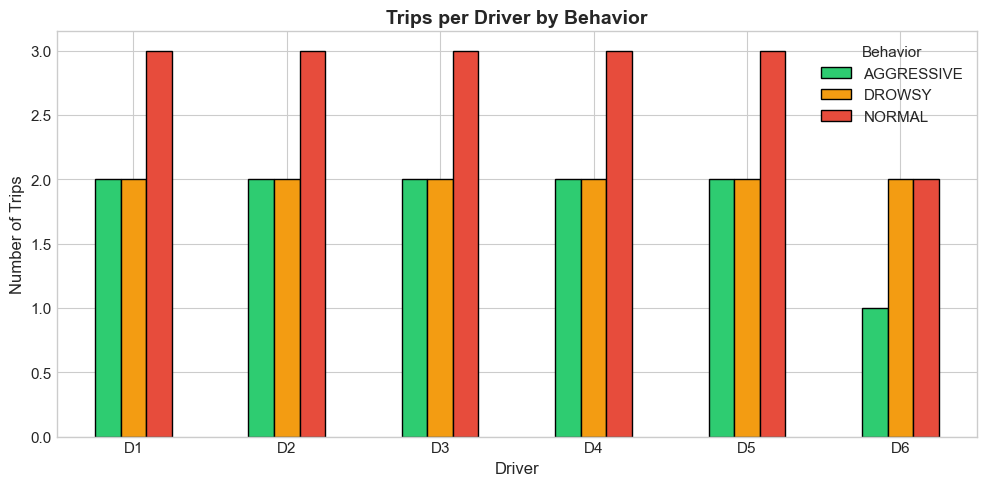


💡 Strategy: Hold out D6 for testing (driver-level split)
   This ensures generalization to NEW DRIVERS


In [8]:
driver_crosstab = analyze_driver_distribution(df, driver_column='driver', behavior_column='behavior')

print("\n👥 Trips per driver:")
driver_counts = df['driver'].value_counts().sort_index()
for driver, count in driver_counts.items():
    print(f"   {driver}: {count} trips")

print("\n🔄 Driver × Behavior:")
print(driver_crosstab)

# Plot using our visualization function
fig = plot_driver_behavior_distribution(driver_crosstab)
plt.savefig(project_root / 'results' / 'figures' / 'driver_behavior_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Strategy: Hold out D6 for testing (driver-level split)")
print("   This ensures generalization to NEW DRIVERS")


## 8. Feature Overview


In [9]:
feature_cols = [c for c in df.columns if c not in ['behavior', 'driver']]

print(f"\n📋 Features ({len(feature_cols)}):")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i}. {feat}")

print("\n📊 Feature Statistics:")
df[feature_cols].describe().T



📋 Features (11):
   1. score_total
   2. score_accelerations
   3. score_brakings
   4. score_turnings
   5. score_weaving
   6. score_drifting
   7. score_overspeeding
   8. score_following
   9. ratio_normal
   10. ratio_drowsy
   11. ratio_aggressive

📊 Feature Statistics:


,count,mean,std,min,25%,50%,75%,max
score_total,40.0,81.357500,12.502572,55.000,74.45000,82.4000,89.55000,100.000
score_accelerations,40.0,83.655000,26.696220,0.000,73.40000,100.0000,100.00000,100.000
score_brakings,40.0,66.995000,40.137609,0.000,33.75000,89.4000,100.00000,100.000
score_turnings,40.0,82.717500,30.992819,0.000,59.27500,100.0000,100.00000,100.000
score_weaving,40.0,87.912500,27.221854,0.000,100.00000,100.0000,100.00000,100.000
score_drifting,40.0,74.712500,17.136768,26.200,64.80000,75.9500,87.15000,100.000
score_overspeeding,40.0,91.695000,18.041191,0.000,92.07500,99.1500,100.00000,100.000
score_following,40.0,81.812500,35.090580,0.000,95.12500,100.0000,100.00000,100.000
ratio_normal,40.0,0.578725,0.278466,0.003,0.34100,0.6195,0.81650,1.000
ratio_drowsy,40.0,0.195850,0.164942,0.000,0.07725,0.1520,0.24650,0.672


## 9. Outlier Analysis

Using our `analyze_outliers_dataframe()` function.



🔍 Outlier Analysis (IQR method):
   ✅ score_total: 0 outliers (0.0%)
   ✅ score_accelerations: 0 outliers (0.0%)
   ⚠️ score_brakings: 10 outliers (25.0%)
   ✅ score_turnings: 0 outliers (0.0%)
   ✅ score_weaving: 0 outliers (0.0%)
   ✅ score_drifting: 0 outliers (0.0%)
   ⚠️ score_overspeeding: 13 outliers (32.5%)
   ✅ score_following: 0 outliers (0.0%)
   ✅ ratio_normal: 0 outliers (0.0%)
   ✅ ratio_drowsy: 1 outliers (2.5%)
   ⚠️ ratio_aggressive: 4 outliers (10.0%)


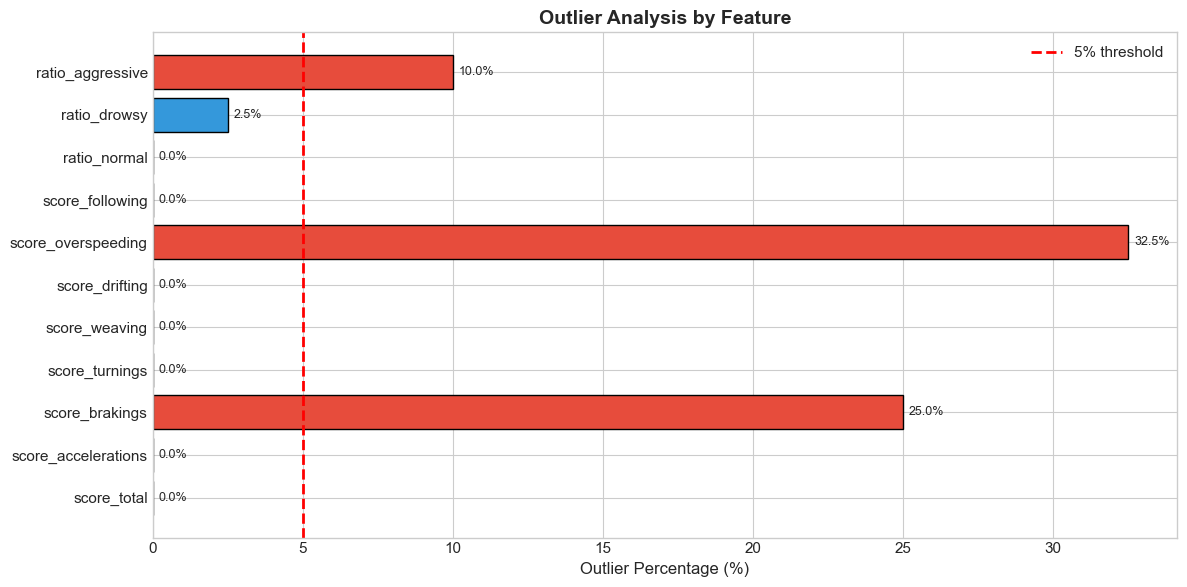

In [10]:
outlier_results = analyze_outliers_dataframe(df, columns=feature_cols)

print("\n🔍 Outlier Analysis (IQR method):")
for result in outlier_results:
    status = "⚠️" if result.has_significant_outliers else "✅"
    print(f"   {status} {result.column}: {result.n_outliers} outliers ({result.outlier_percentage:.1f}%)")

# Plot outlier summary
fig = plot_outlier_summary(outlier_results, title='Outlier Analysis by Feature')
plt.savefig(project_root / 'results' / 'figures' / 'outlier_analysis_classification.png', dpi=300, bbox_inches='tight')
plt.show()


## 10. Feature Distributions by Behavior

Using our `plot_feature_by_target()` function.


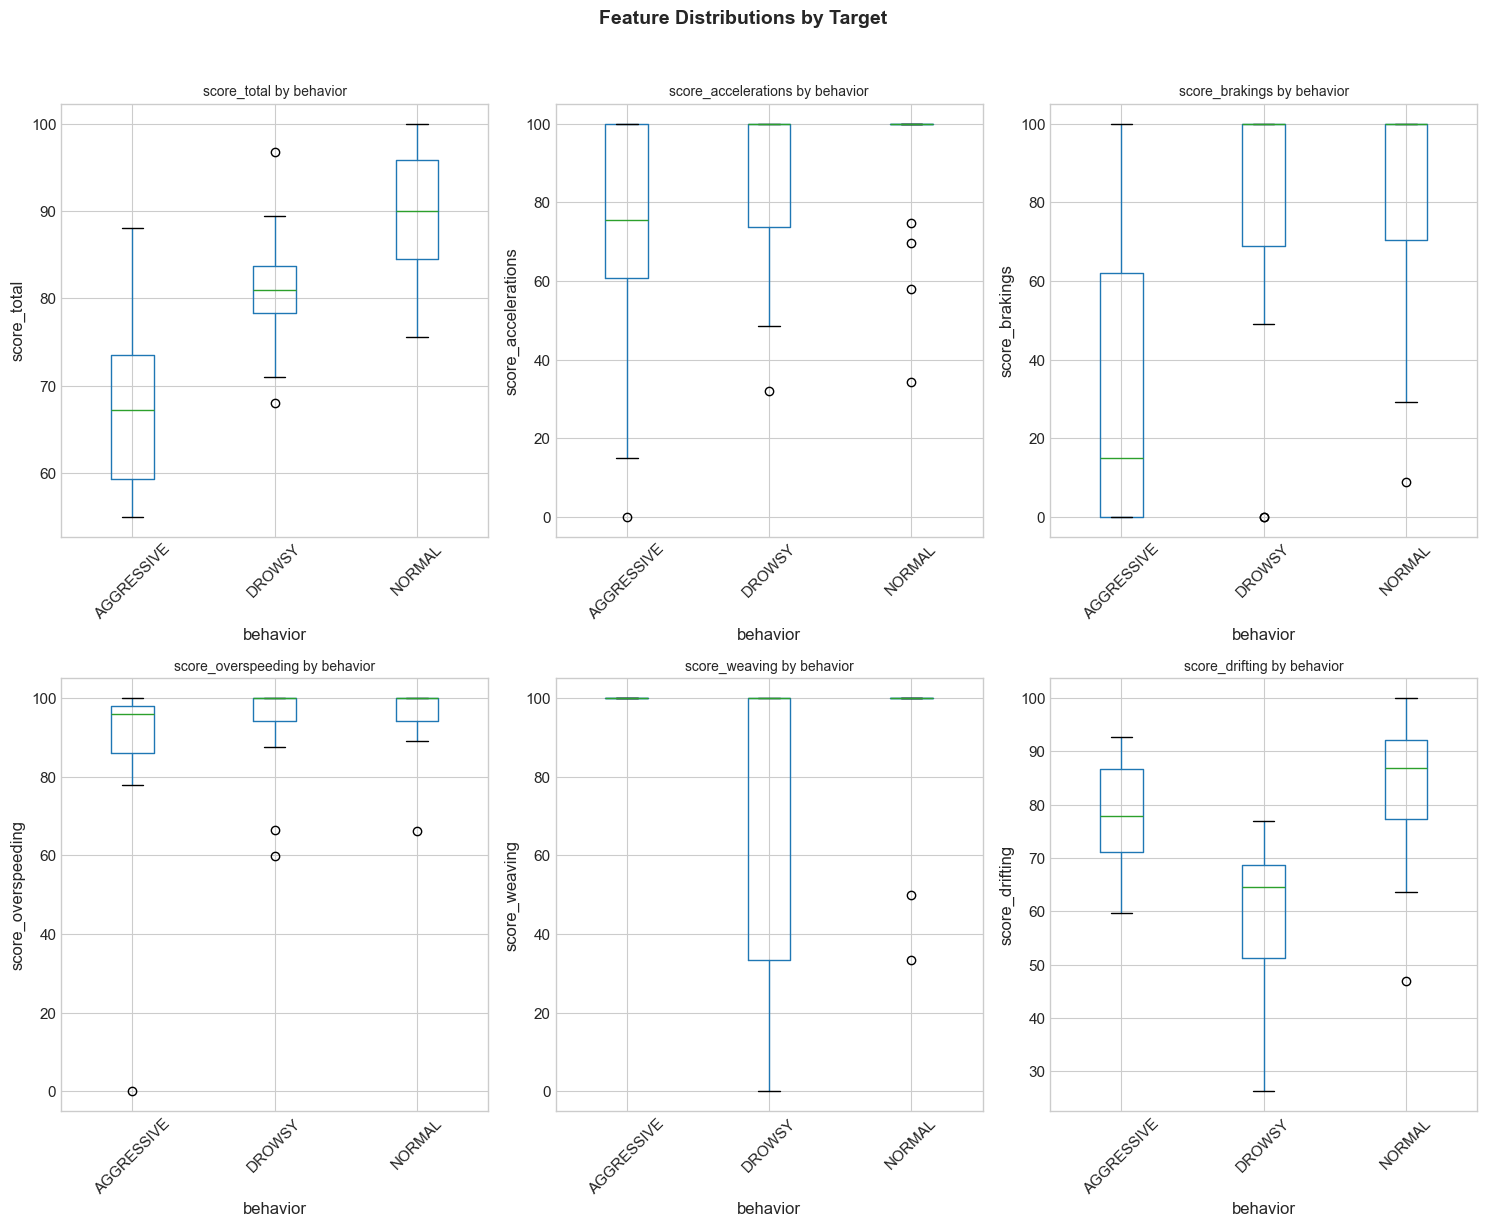


✅ Clear separation indicates good classification potential


In [11]:
key_features = ['score_total', 'score_accelerations', 'score_brakings',
                'score_overspeeding', 'score_weaving', 'score_drifting']
key_features = [f for f in key_features if f in df.columns]

fig = plot_feature_by_target(df, feature_columns=key_features, target_column='behavior', n_cols=3)
plt.savefig(project_root / 'results' / 'figures' / 'feature_distributions_classification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Clear separation indicates good classification potential")


## 11. Correlation Analysis

Using our `analyze_correlations()` function.


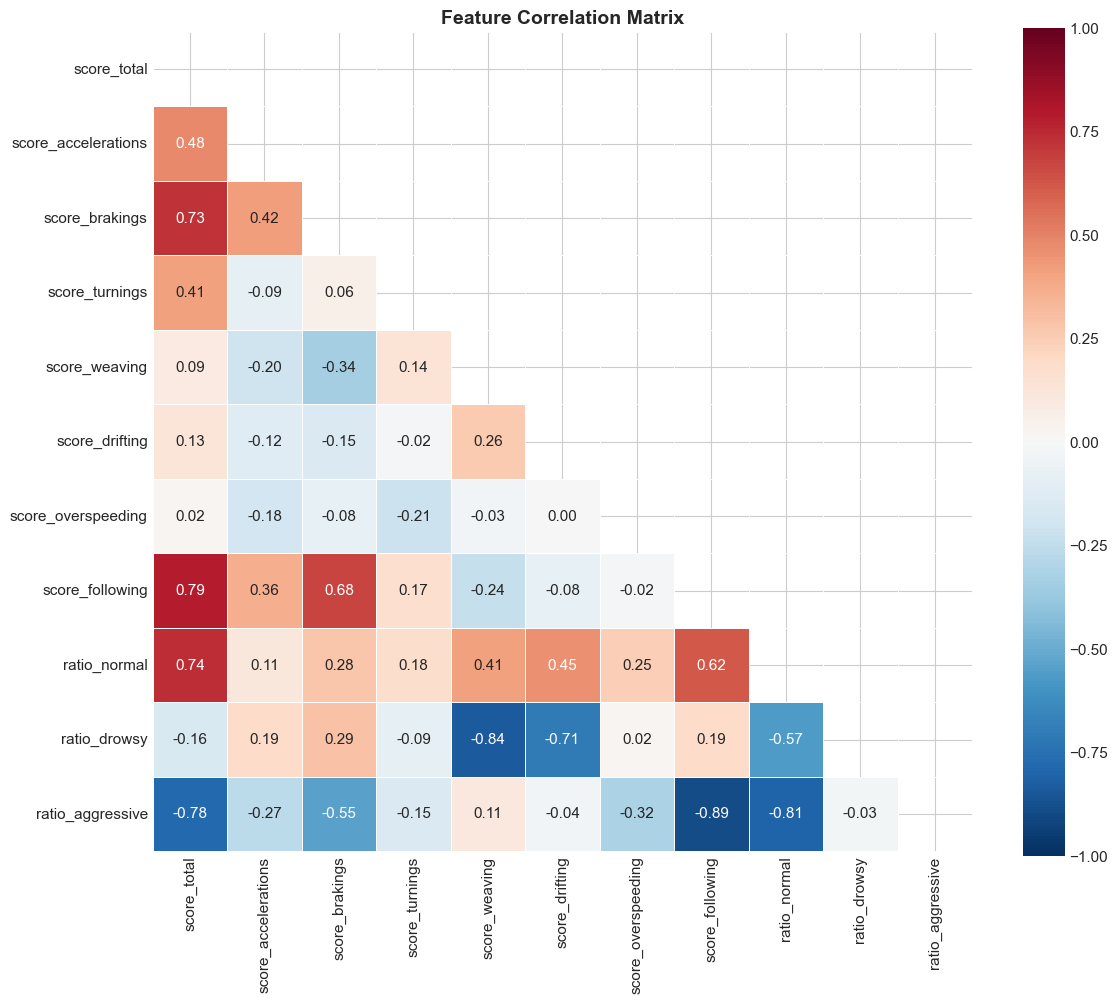


⚠️ Highly correlated features (|r| > 0.8):
   score_weaving ↔ ratio_drowsy: -0.844
   score_following ↔ ratio_aggressive: -0.894
   ratio_normal ↔ ratio_aggressive: -0.806


In [12]:
corr_result = analyze_correlations(df, columns=feature_cols, threshold=0.8)

# Plot correlation matrix
fig = plot_correlation_matrix(df, columns=feature_cols)
plt.savefig(project_root / 'results' / 'figures' / 'correlation_matrix_classification.png', dpi=300, bbox_inches='tight')
plt.show()

if corr_result.high_correlation_pairs:
    print("\n⚠️ Highly correlated features (|r| > 0.8):")
    for f1, f2, corr in corr_result.high_correlation_pairs:
        print(f"   {f1} ↔ {f2}: {corr:.3f}")
else:
    print("\n✅ No highly correlated features")

if corr_result.multicollinearity_warning:
    print("\n⚠️ Multicollinearity detected - consider Ridge regularization")


## 12. Key Takeaways

### ✅ Data Quality
- Real-world telemetry (not synthetic)
- Balanced classes (from quality report)
- Multiple drivers for generalization testing
- Variable trip lengths handled via aggregation

### 🎯 Feature Engineering Success
- **Aggregate statistics**: Robust to variable trip lengths
- **Domain-driven**: Score-based features from telematics research
- **Production-ready**: Easy to compute in real-time
- **Interpretable**: Clear meaning for domain experts

### 📊 Modeling Strategy
1. **Driver-level split**: Hold out D6 to test generalization
2. **Model comparison**: Logistic Regression, Random Forest, CNN
3. **Evaluation**: F1-score, confusion matrix, learning curves
4. **Business relevance**: Fleet safety, insurance risk, driver coaching

---

**✅ EDA complete → Ready for modeling in `02_classification.ipynb`**

